# Imports and setup

In [3]:
########## 1. Import required libraries ##########

import pandas as pd
import numpy as np
import re
import math
import pandas as pd
import matplotlib.pyplot as plt

# Text and feature engineering
from sklearn.feature_extraction.text import TfidfVectorizer

# Evaluation and tuning
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, roc_curve, auc, classification_report)

# Classifiers
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE


In [ ]:

# Text cleaning & stopwords
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

### Step 1: Preprocess and Save Processed Data to CSV 

##### Functions to preprocess data

In [1]:
########## 2. Define text preprocessing methods ##########

def remove_html(text):
    """Remove HTML tags using a regex."""
    html = re.compile(r'<.*?>')
    return html.sub(r'', text)

def remove_emoji(text):
    """Remove emojis using a regex pattern."""
    emoji_pattern = re.compile("[" u"\U0001F600-\U0001F64F"  
                               u"\U0001F300-\U0001F5FF"  
                               u"\U0001F680-\U0001F6FF"  
                               u"\U0001F1E0-\U0001F1FF"  
                               u"\U00002702-\U000027B0"  
                               u"\U000024C2-\U0001F251" "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

def remove_stopwords(text):
    stop_words = set(stopwords.words('english'))
    custom_stopwords = {}  # Define your custom stopwords here
    stop_words.update(custom_stopwords)
    return " ".join([word for word in text.split() if word.lower() not in stop_words])

def clean_str(string):
    """
    Clean text by removing non-alphanumeric characters,
    and convert it to lowercase.
    """
    string = re.sub(r"[^A-Za-z0-9(),.!?\'\`]", " ", string)
    string = re.sub(r"\'s", " \'s", string)
    string = re.sub(r"\'ve", " \'ve", string)
    string = re.sub(r"\)", " ) ", string)
    string = re.sub(r"\?", " ? ", string)
    string = re.sub(r"\s{2,}", " ", string)
    string = re.sub(r"\\", "", string)
    string = re.sub(r"\'", "", string)
    string = re.sub(r"\"", "", string)
    return string.strip().lower()

def check_data_leakage(X_train, X_test):
    train_set = set(map(tuple, X_train))
    test_set = set(map(tuple, X_test))

    leaked_samples = train_set.intersection(test_set)
    print("\n🔍 Checking Data Leakage...")
    print(f"⚠️ {len(leaked_samples)} samples from test data are also in training data.")

    if len(leaked_samples) > 0:
        print("❌ Data Leakage Detected! Test data should not exist in training set.")
    else:
        print("✅ No Data Leakage Detected.")

##COMAPRES TEST ACCURACY TO TRAIN ACCURACY
def check_overfitting(model, X_train, y_train, X_test, y_test):
    train_preds = model.predict(X_train)
    test_preds = model.predict(X_test)
    train_acc = accuracy_score(y_train, train_preds)
    test_acc = accuracy_score(y_test, test_preds)
    
    print("\n🔍 Checking Overfitting...")
    print(f"📊 Training Accuracy: {train_acc:.4f}")
    print(f"📊 Test Accuracy: {test_acc:.4f}")

    if train_acc > test_acc + 0.10:
        print("❌ Possible Overfitting: Model performs much better on training data.")
    else:
        print("✅ No significant overfitting detected.")

#Line Chart (Trend over Repeats)
def plot_metric_trends(csv_path):

    df = pd.read_csv(csv_path)
    plt.figure(figsize=(12, 6))
    metric_columns = ['Accuracy', 'Precision', 'Recall', 'F1', 'AUC']

    for metric in metric_columns:
        plt.plot(df['Repeat'], df[metric], marker='o', label=metric)

    # Chart styling
    plt.xlabel("Repeat")
    plt.ylabel("Score")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

##### Download and read data, save to csv files for repeatable use

In [7]:
########## 3. Download & read data ##########
project = 'tensorflow'
text_col = 'Title+Body'


In [7]:
path = f'C:/Users/chibu/Documents/ISE-solution-main/Coursework/datasets/{project}.csv'

data = pd.read_csv(path).fillna('')
data['Title+Body'] = data.apply(lambda row: row['Title'] + '. ' + row['Body'] if pd.notna(row['Body']) else row['Title'], axis=1)
#text_col = 'Title+Body'

data[text_col] = data[text_col].apply(remove_html)
data[text_col] = data[text_col].apply(remove_emoji)
data[text_col] = data[text_col].apply(remove_stopwords)
data[text_col] = data[text_col].apply(clean_str)

data.to_csv(f'{project}_processed_data.csv', index=False)


##### Load and check datasets in Title+Body Files

In [8]:
baseline_path = 'C:/Users/chibu/Documents/ISE-solution-main/Coursework/trial2'

df = pd.read_csv(f'{project}_processed_data.csv')
df.head()

,Unnamed: 0,Repository,Number,State,Title,Body,Labels,Comments,Codes,Commands,class,related,Title+Body
0,0,tensorflow,8704,closed,TensorFlow drops the first batch?,### Description\r\n\r\nI'm trying to understan...,NaN,['More logging output. You can see that there ...,"[""\r\n'image/id': tf.FixedLenFeature(shape=[],...","['TFRecord', 'image/id', 'TFRecord', 'num_samp...",1,0,tensorflow drops first batch ? . description t...
1,1,tensorflow,10245,closed,Implement Focused Online Learning which conver...,![image](https://cloud.githubusercontent.com/a...,stat:awaiting response type:feature,['Thoughts on this feature request @fchollet?'...,[],[],1,0,implement focused online learning converges fa...
2,2,tensorflow,27143,closed,[TF 2.0] tf 2 around 40 times slower than tf 1...,**System information**\r\n- Have I written cus...,NaN,"[""Ah!\r\n\r\nThis is the subtlest and most com...",['shell\r\n(tf1) $ python expm.py \r\nBENCHMAR...,"['expm', 'taylor_v2', '_pywrap_tensorflow_inte...",1,0,tf 2.0 tf 2 around 40 times slower tf 1 unroll...
3,3,tensorflow,12808,closed,tensorflow performance issue for map_fn and ga...,I am trying to understand more about certain s...,NaN,['This question is better asked on [StackOver...,[],"['map_fn', 'tree_offset_tensor', 'map_fn', 'ge...",1,0,tensorflow performance issue map fn gather. tr...
4,4,tensorflow,23049,open,Ghost Batch Normalization performance,GBN seems to be at least twice as slow as regu...,comp:keras comp:model stat:awaiting tensorflower,['Thank you for your post. We noticed you have...,['bash\r\n\r\ngit clone git@github.com:tensorf...,['virtual_batch_size=batch_size'],1,0,ghost batch normalization performance. gbn see...


### Step 2: Configure parameters and start training

##### Set values, params and load csv files

In [9]:
# Number of repeated experiments
REPEAT = 30

# Output CSV file name
results_dir = "C:/Users/chibu/Documents/ISE-solution-main/Coursework/trial2/results"
out_csv_name = f"{results_dir}/{project}_Results.csv"

# Convert and save metrics for all models
def save_model_metrics(metrics_list, filename):
    df = pd.DataFrame(metrics_list)
    df.to_csv(f"{results_dir}/{filename}", index=False)
    print(f"Saved: {filename}")
    print(df.mean(numeric_only=True))
    print("\n")

# Hyperparameter grid for Naive Bayes
params = {'var_smoothing': np.logspace(-12, 0, 13)}

# Lists to store metrics across repeated runs
accuracies, precisions, recalls, f1_scores, auc_values = [], [], [], [], []

##### Perform Testing on Baseline code from Lab 1

In [10]:
nb_metrics = []
# Load dataset for this iteration
data = pd.read_csv(f'{project}_processed_data.csv')
X = data[text_col]
y = data['class']

for repeated_time in range(REPEAT):
    

    # Train-test split (70/30)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=repeated_time, shuffle=True
    )

    # Apply TF-IDF vectorization
    tfidf = TfidfVectorizer(ngram_range=(1, 2), max_features=1000)
    X_train_tfidf = tfidf.fit_transform(X_train).toarray()
    X_test_tfidf = tfidf.transform(X_test).toarray()

    # Train and Evaluate Naive Bayes with Cross-Validation
    nb_clf = GaussianNB()
    grid = GridSearchCV(nb_clf, params, cv=5, scoring='roc_auc')
    grid.fit(X_train_tfidf, y_train)
    best_nb = grid.best_estimator_
    y_pred_nb = best_nb.predict(X_test_tfidf)
    
    nb_metrics.append({
        "Repeat": repeated_time,
        "Accuracy": accuracy_score(y_test, y_pred_nb),
        "Precision": precision_score(y_test, y_pred_nb, average='macro'),
        "Recall": recall_score(y_test, y_pred_nb, average='macro'),
        "F1": f1_score(y_test, y_pred_nb, average='macro'),
        "AUC": auc(*roc_curve(y_test, y_pred_nb, pos_label=1)[:2])
    })

    save_model_metrics(nb_metrics, f'{project}_NaiveBayes_Metrics.csv')

Saved: tensorflow_NaiveBayes_Metrics.csv
Repeat       0.000000
Accuracy     0.574944
Precision    0.633698
Recall       0.727817
F1           0.548072
AUC          0.727817
dtype: float64


Saved: tensorflow_NaiveBayes_Metrics.csv
Repeat       0.500000
Accuracy     0.549217
Precision    0.624247
Recall       0.703996
F1           0.527059
AUC          0.703996
dtype: float64


Saved: tensorflow_NaiveBayes_Metrics.csv
Repeat       1.000000
Accuracy     0.555556
Precision    0.627254
Recall       0.710437
F1           0.532547
AUC          0.710437
dtype: float64


Saved: tensorflow_NaiveBayes_Metrics.csv
Repeat       1.500000
Accuracy     0.560962
Precision    0.630200
Recall       0.706944
F1           0.540024
AUC          0.706944
dtype: float64


Saved: tensorflow_NaiveBayes_Metrics.csv
Repeat       2.000000
Accuracy     0.565548
Precision    0.633954
Recall       0.711273
F1           0.545033
AUC          0.711273
dtype: float64


Saved: tensorflow_NaiveBayes_Metrics.csv
Repeat   

##### View progressive results

In [11]:
df = pd.read_csv(f'{baseline_path}/results/{project}_NaiveBayes_Metrics.csv')
df.head() 

,Repeat,Accuracy,Precision,Recall,F1,AUC
0,0,0.574944,0.633698,0.727817,0.548072,0.727817
1,1,0.523490,0.614797,0.680176,0.506047,0.680176
2,2,0.568233,0.633268,0.723317,0.543523,0.723317
3,3,0.577181,0.639039,0.696465,0.562457,0.696465
4,4,0.583893,0.648970,0.728592,0.565066,0.728592


##### Save final results to csv file

In [12]:
# === Calculate final averages from all repeats ===
final_metrics = {
    "Total_Repeats": REPEAT,
    "Avg_Accuracy": np.mean([m["Accuracy"] for m in nb_metrics]),
    "Avg_Precision": np.mean([m["Precision"] for m in nb_metrics]),
    "Avg_Recall": np.mean([m["Recall"] for m in nb_metrics]),
    "Avg_F1": np.mean([m["F1"] for m in nb_metrics]),
    "Avg_AUC": np.mean([m["AUC"] for m in nb_metrics])
}

save_model_metrics([final_metrics], f'{project}_NaiveBayes_Final_Metrics.csv')

Saved: tensorflow_NaiveBayes_Final_Metrics.csv
Total_Repeats    30.000000
Avg_Accuracy      0.547054
Avg_Precision     0.630865
Avg_Recall        0.703937
Avg_F1            0.529010
Avg_AUC           0.703937
dtype: float64




##### Load results for baseline 

In [ ]:
df = pd.read_csv(f'{baseline_path}/results/{project}_NaiveBayes_Final_Metrics.csv')
df.head() 

,Total_Repeats,Avg_Accuracy,Avg_Precision,Avg_Recall,Avg_F1,Avg_AUC
0,30,0.547054,0.630865,0.703937,0.52901,0.703937


### Examine datasets for data leakage and overfitting and class ditribution to know what to expect when it comes to validating my results based on baseline

In [14]:


#check where these variables are coming from
# For baseline Naive Bayes testing:
check_data_leakage(X_train_tfidf, X_test_tfidf)
check_overfitting(best_nb, X_train_tfidf, y_train, X_test_tfidf, y_test)

print("\nClass Distribution in Training Set:")
print(y_train.value_counts())
print("\nClassification Report (Naive Bayes):")
print(classification_report(y_test, y_pred_nb))


🔍 Checking Data Leakage...
⚠️ 0 samples from test data are also in training data.
✅ No Data Leakage Detected.

🔍 Checking Overfitting...
📊 Training Accuracy: 0.6040
📊 Test Accuracy: 0.5302
✅ No significant overfitting detected.

Class Distribution in Training Set:
class
0    840
1    203
Name: count, dtype: int64

Classification Report (Naive Bayes):
              precision    recall  f1-score   support

           0       0.98      0.44      0.61       371
           1       0.26      0.95      0.41        76

    accuracy                           0.53       447
   macro avg       0.62      0.70      0.51       447
weighted avg       0.85      0.53      0.58       447



#####  Line Chart (Trend over Repeats)

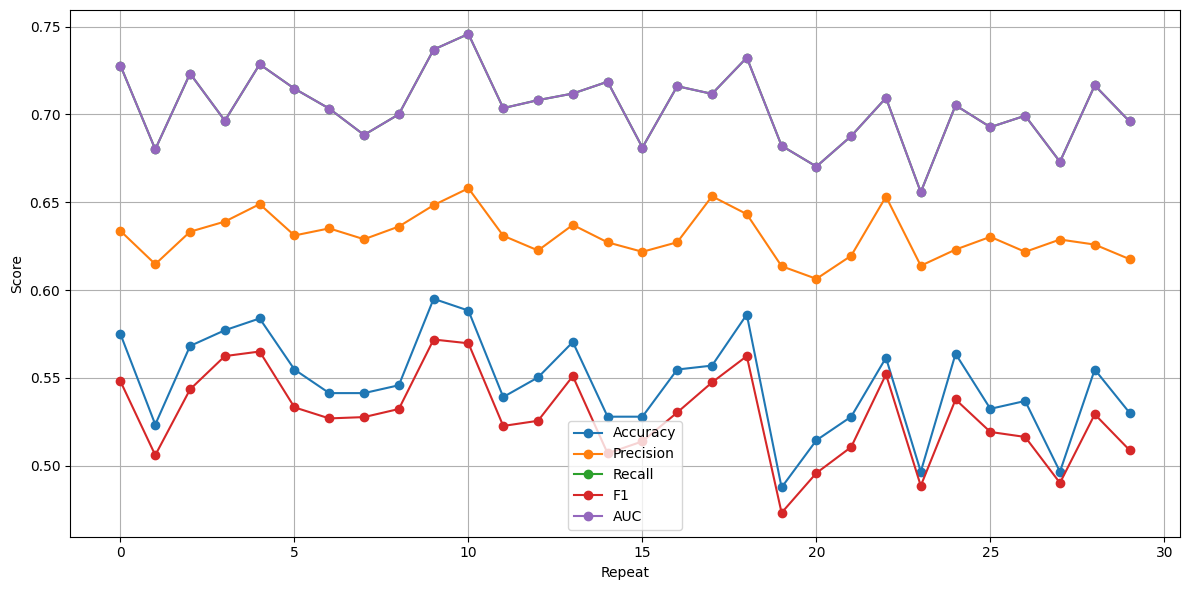

In [11]:
plot_metric_trends(f'{baseline_path}/results/{project}_NaiveBayes_Metrics.csv')

##### Perform Testing with Random Forest

In [15]:
rf_metrics = []

# Load dataset for this iteration
data_rf = pd.read_csv(f'{project}_processed_data.csv')
X_rf = data_rf[text_col]
y_rf = data_rf['class']

for repeated_time in range(REPEAT):
    
    # Train-test split (70/30)
    X_train_rf, X_test_rf, y_train_rf, y_test_rf = train_test_split(
        X_rf, y_rf, test_size=0.3, random_state=repeated_time, shuffle=True
    )

    # Apply TF-IDF vectorization
    tfidf_rf = TfidfVectorizer(ngram_range=(1, 2), max_features=1000)
    X_train_tfidf_rf = tfidf_rf.fit_transform(X_train_rf).toarray()
    X_test_tfidf_rf = tfidf_rf.transform(X_test_rf).toarray()

    # Train and Evaluate Random Forest
    rf_clf = RandomForestClassifier(n_estimators=100, max_depth=20)
    rf_clf.fit(X_train_tfidf_rf, y_train_rf)
    y_pred_rf = rf_clf.predict(X_test_tfidf_rf)

    rf_metrics.append({
        "Repeat": repeated_time,
        "Accuracy": accuracy_score(y_test_rf, y_pred_rf),
        "Precision": precision_score(y_test_rf, y_pred_rf, average='macro'),
        "Recall": recall_score(y_test_rf, y_pred_rf, average='macro'),
        "F1": f1_score(y_test_rf, y_pred_rf, average='macro'),
        "AUC": auc(*roc_curve(y_test_rf, y_pred_rf, pos_label=1)[:2])
    })

    save_model_metrics(rf_metrics, f'{project}_RandomForest_Metrics.csv')


Saved: tensorflow_RandomForest_Metrics.csv
Repeat       0.000000
Accuracy     0.859060
Precision    0.800719
Recall       0.632046
F1           0.665582
AUC          0.632046
dtype: float64


Saved: tensorflow_RandomForest_Metrics.csv
Repeat       0.500000
Accuracy     0.857942
Precision    0.813947
Recall       0.632912
F1           0.666928
AUC          0.632912
dtype: float64


Saved: tensorflow_RandomForest_Metrics.csv
Repeat       1.000000
Accuracy     0.857569
Precision    0.822132
Recall       0.625263
F1           0.657851
AUC          0.625263
dtype: float64


Saved: tensorflow_RandomForest_Metrics.csv
Repeat       1.500000
Accuracy     0.844519
Precision    0.806500
Recall       0.613355
F1           0.639444
AUC          0.613355
dtype: float64


Saved: tensorflow_RandomForest_Metrics.csv
Repeat       2.000000
Accuracy     0.846532
Precision    0.813267
Recall       0.621201
F1           0.649427
AUC          0.621201
dtype: float64


Saved: tensorflow_RandomForest_Metrics.c

##### Save results to csv file

In [16]:
# === Calculate final averages from all repeats ===
final_metrics = {
    "Total_Repeats": REPEAT,
    "Avg_Accuracy": np.mean([m["Accuracy"] for m in rf_metrics]),
    "Avg_Precision": np.mean([m["Precision"] for m in rf_metrics]),
    "Avg_Recall": np.mean([m["Recall"] for m in rf_metrics]),
    "Avg_F1": np.mean([m["F1"] for m in rf_metrics]),
    "Avg_AUC": np.mean([m["AUC"] for m in rf_metrics])
}

save_model_metrics([final_metrics], f'{project}_RandomForest_Final_Metrics.csv')

Saved: tensorflow_RandomForest_Final_Metrics.csv
Total_Repeats    30.000000
Avg_Accuracy      0.847502
Avg_Precision     0.818692
Avg_Recall        0.617137
Avg_F1            0.643924
Avg_AUC           0.617137
dtype: float64




##### Load results for Random Forest 

In [17]:
df = pd.read_csv(f'{baseline_path}/results/{project}_RandomForest_Final_Metrics.csv')
df.head() 

,Total_Repeats,Avg_Accuracy,Avg_Precision,Avg_Recall,Avg_F1,Avg_AUC
0,30,0.847502,0.818692,0.617137,0.643924,0.617137


#####  Line Chart (Trend over Repeats)

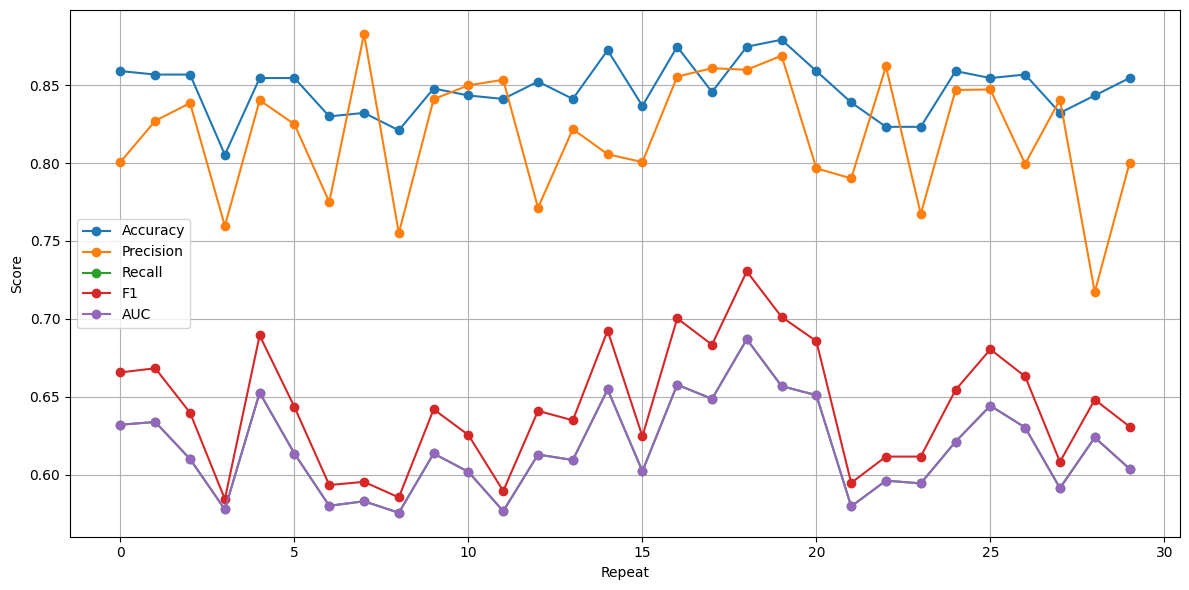

In [12]:
plot_metric_trends(f'{baseline_path}/results/{project}_RandomForest_Metrics.csv')

##### My own improvement: perform testing with the hybrid Model 

In [18]:
hybrid_metrics = []
# Load dataset for this iteration
data = pd.read_csv(f'{project}_processed_data.csv')
X_hybrid = data[text_col]
y_hybrid = data['class']

for repeated_time in range(REPEAT):
    

    X_train_hybrid, X_test_hybrid, y_train_hybrid, y_test_hybrid = train_test_split(
        X_hybrid, y_hybrid, test_size=0.3, random_state=repeated_time, shuffle=True
    )

    tfidf_hybrid = TfidfVectorizer(ngram_range=(1, 2), max_features=1000)
    X_train_tfidf_hybrid = tfidf_hybrid.fit_transform(X_train_hybrid).toarray()
    X_test_tfidf_hybrid = tfidf_hybrid.transform(X_test_hybrid).toarray()

    rf_clf_hybrid = RandomForestClassifier(n_estimators=100, max_depth=20)
    rf_clf_hybrid.fit(X_train_tfidf_hybrid, y_train_hybrid)

    logreg_clf_hybrid = LogisticRegression(max_iter=2000)
    voting_clf_hybrid = VotingClassifier(estimators=[('rf', rf_clf_hybrid), ('logreg', logreg_clf_hybrid)], voting='soft')
    voting_clf_hybrid.fit(X_train_tfidf_hybrid, y_train_hybrid)

    y_pred_hybrid = voting_clf_hybrid.predict(X_test_tfidf_hybrid)

    hybrid_metrics.append({
        "Repeat": repeated_time,
        "Accuracy": accuracy_score(y_test_hybrid, y_pred_hybrid),
        "Precision": precision_score(y_test_hybrid, y_pred_hybrid, average='macro'),
        "Recall": recall_score(y_test_hybrid, y_pred_hybrid, average='macro'),
        "F1": f1_score(y_test_hybrid, y_pred_hybrid, average='macro'),
        "AUC": auc(*roc_curve(y_test_hybrid, y_pred_hybrid, pos_label=1)[:2])
    })

    save_model_metrics(hybrid_metrics, f'{project}_HybridModel_Metrics.csv')


Saved: tensorflow_HybridModel_Metrics.csv
Repeat       0.000000
Accuracy     0.861298
Precision    0.844647
Recall       0.617971
F1           0.650957
AUC          0.617971
dtype: float64


Saved: tensorflow_HybridModel_Metrics.csv
Repeat       0.500000
Accuracy     0.857942
Precision    0.844605
Recall       0.617982
F1           0.650121
AUC          0.617982
dtype: float64


Saved: tensorflow_HybridModel_Metrics.csv
Repeat       1.000000
Accuracy     0.860552
Precision    0.853111
Recall       0.622171
F1           0.656082
AUC          0.622171
dtype: float64


Saved: tensorflow_HybridModel_Metrics.csv
Repeat       1.500000
Accuracy     0.845638
Precision    0.833932
Recall       0.605664
F1           0.629366
AUC          0.605664
dtype: float64


Saved: tensorflow_HybridModel_Metrics.csv
Repeat       2.000000
Accuracy     0.845638
Precision    0.836321
Recall       0.608707
F1           0.633596
AUC          0.608707
dtype: float64


Saved: tensorflow_HybridModel_Metrics.csv
Rep

##### Save results to csv file

In [19]:
# === Calculate final averages from all repeats ===
final_metrics = {
    "Total_Repeats": REPEAT,
    "Avg_Accuracy": np.mean([m["Accuracy"] for m in hybrid_metrics]),
    "Avg_Precision": np.mean([m["Precision"] for m in hybrid_metrics]),
    "Avg_Recall": np.mean([m["Recall"] for m in hybrid_metrics]),
    "Avg_F1": np.mean([m["F1"] for m in hybrid_metrics]),
    "Avg_AUC": np.mean([m["AUC"] for m in hybrid_metrics])
}

save_model_metrics([final_metrics], f'{project}_HybridModel_Final_Metrics.csv')

Saved: tensorflow_HybridModel_Final_Metrics.csv
Total_Repeats    30.000000
Avg_Accuracy      0.851305
Avg_Precision     0.861006
Avg_Recall        0.613747
Avg_F1            0.641057
Avg_AUC           0.613747
dtype: float64




##### Load results for Hybrid Model 

In [20]:
df = pd.read_csv(f'{baseline_path}/results/{project}_HybridModel_Final_Metrics.csv')
df.head() 

,Total_Repeats,Avg_Accuracy,Avg_Precision,Avg_Recall,Avg_F1,Avg_AUC
0,30,0.851305,0.861006,0.613747,0.641057,0.613747


##### Line Chart (Trend over Repeats)

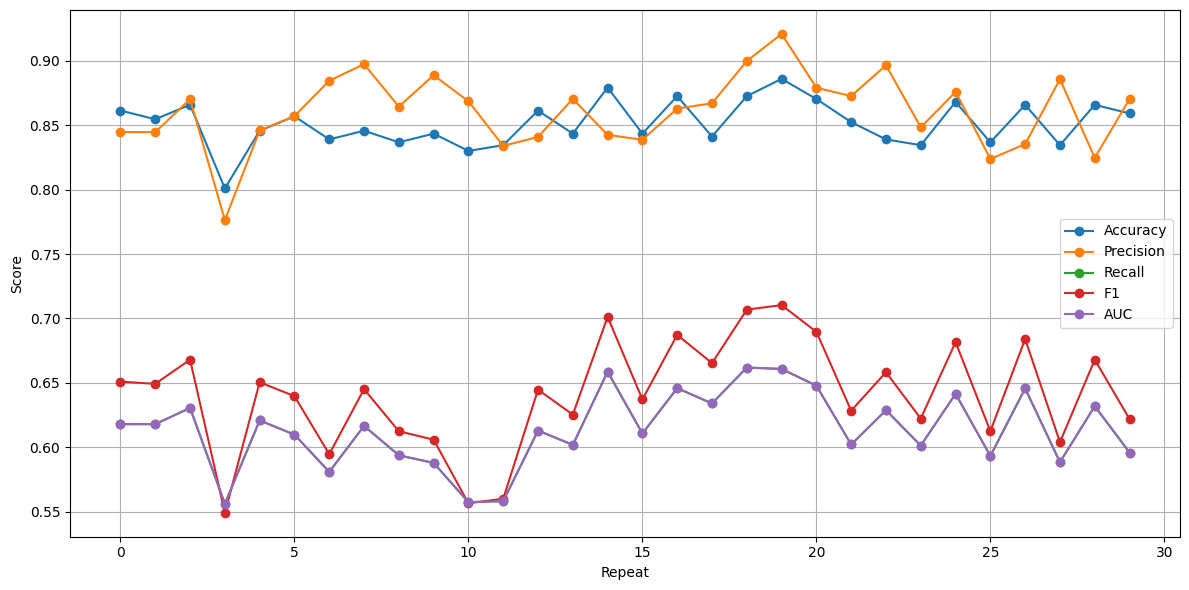

In [14]:
plot_metric_trends(f'{baseline_path}/results/{project}_HybridModel_Metrics.csv')

### Step 3: Validate results

###### Now that the training has been complete with the baselineto be able to compare with my own improvements. 
###### I want to ensure my results can be trusted so, FOR THE HYBRID MODEL, I will test on holdout data, check for data leakage an overfitting. I will also check the class distribution of the training set and perfrom SMOTE to Balance the dataset and retest witht the hybrid model, to see if there any differences in results

##### Test Hybrid Model on Holdout Data ---Shoukld this repeat 30 times???

In [21]:
###0 IS A NONBUG, SO IT IS WHAT SHOULD BE PRE4DICTED AS NONBUG

# Define function to test trained hybrid model on holdout set
def test_on_holdout_hybrid(model):
    holdout_data_hybrid = pd.read_csv(f'{project}_processed_data_holdout.csv')
    holdout_text_hybrid = holdout_data_hybrid[text_col]
    holdout_labels_hybrid = holdout_data_hybrid['class']

    tfidf_hybrid_holdout = TfidfVectorizer(ngram_range=(1, 2), max_features=1000)
    X_holdout_hybrid = tfidf_hybrid_holdout.fit_transform(holdout_text_hybrid).toarray()

    holdout_preds_hybrid = model.predict(X_holdout_hybrid)
    print("\n🔍 Holdout Set Performance (Hybrid Model):")
    print(classification_report(holdout_labels_hybrid, holdout_preds_hybrid, target_names=['Non-Bug', 'Bug']))

    # Load full processed dataset
data = pd.read_csv(f'{project}_processed_data.csv')

# Create holdout split (90% train/test, 10% holdout)
train_test_data, holdout_data = train_test_split(data, test_size=0.1, random_state=42)

# Save to CSV for consistent usage across notebooks
train_test_data.to_csv(f'{project}_processed_train_test_data_holdout.csv', index=False)
holdout_data.to_csv(f'{project}_processed_data_holdout.csv', index=False)




hybrid_holdout_metrics = []

# Load 90% dataset for training/testing splits
data_hybrid_holdout = pd.read_csv(f'{project}_processed_train_test_data_holdout.csv')
X_hybrid_holdout = data_hybrid_holdout[text_col]
y_hybrid_holdout = data_hybrid_holdout['class']

for repeated_time in range(REPEAT):
    # Split into 70/30
    X_train_hybrid, X_test_hybrid, y_train_hybrid, y_test_hybrid = train_test_split(
        X_hybrid_holdout, y_hybrid_holdout, test_size=0.3, random_state=repeated_time, shuffle=True
    )

    # TF-IDF
    tfidf_hybrid = TfidfVectorizer(ngram_range=(1, 2), max_features=1000)
    X_train_tfidf_hybrid = tfidf_hybrid.fit_transform(X_train_hybrid).toarray()
    X_test_tfidf_hybrid = tfidf_hybrid.transform(X_test_hybrid).toarray()

    # Random Forest
    rf_clf_hybrid = RandomForestClassifier(n_estimators=100, max_depth=20)
    rf_clf_hybrid.fit(X_train_tfidf_hybrid, y_train_hybrid)

    # Hybrid Model: Random Forest + Logistic Regression
    logreg_clf_hybrid = LogisticRegression(max_iter=2000)
    voting_clf_hybrid = VotingClassifier(estimators=[
        ('rf', rf_clf_hybrid), 
        ('logreg', logreg_clf_hybrid)
    ], voting='soft')
    voting_clf_hybrid.fit(X_train_tfidf_hybrid, y_train_hybrid)
    y_pred_hybrid = voting_clf_hybrid.predict(X_test_tfidf_hybrid)

    # Save metrics for each repeat
    hybrid_holdout_metrics.append({
        "Repeat": repeated_time,
        "Accuracy": accuracy_score(y_test_hybrid, y_pred_hybrid),
        "Precision": precision_score(y_test_hybrid, y_pred_hybrid, average='macro'),
        "Recall": recall_score(y_test_hybrid, y_pred_hybrid, average='macro'),
        "F1": f1_score(y_test_hybrid, y_pred_hybrid, average='macro'),
        "AUC": auc(*roc_curve(y_test_hybrid, y_pred_hybrid, pos_label=1)[:2])
    })

# Save all repeated metrics to CSV
#save_model_metrics(hybrid_holdout_metrics, f'{project}_HybridModel_Holdout_Metrics.csv')



# Evaluate on true holdout portion
test_on_holdout_hybrid(voting_clf_hybrid)



🔍 Holdout Set Performance (Hybrid Model):
              precision    recall  f1-score   support

     Non-Bug       0.80      1.00      0.89       119
         Bug       0.00      0.00      0.00        30

    accuracy                           0.80       149
   macro avg       0.40      0.50      0.44       149
weighted avg       0.64      0.80      0.71       149



c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


##### Save results to csv file

In [ ]:
## Save results here

##### Load results for test on holdout

In [ ]:
#df = pd.read_csv("processed_data_holdout.csv")
#df.head() 

##### Check for data leakage and overfitting

In [22]:
#check where these variables are coming from
check_data_leakage(X_train_tfidf_hybrid, X_test_tfidf_hybrid)
check_overfitting(voting_clf_hybrid, X_train_tfidf_hybrid, y_train_hybrid, X_test_tfidf_hybrid, y_test_hybrid)


🔍 Checking Data Leakage...
⚠️ 0 samples from test data are also in training data.
✅ No Data Leakage Detected.

🔍 Checking Overfitting...
📊 Training Accuracy: 0.9659
📊 Test Accuracy: 0.8387
❌ Possible Overfitting: Model performs much better on training data.


##### Check class distribution 

In [23]:
print("\nClass Distribution in Training Set:")
print(y_train_hybrid.value_counts())
print("\nClassification Report:")
print(classification_report(y_test_hybrid, y_pred_hybrid))


Class Distribution in Training Set:
class
0    768
1    170
Name: count, dtype: int64

Classification Report:
              precision    recall  f1-score   support

           0       0.83      1.00      0.91       324
           1       1.00      0.18      0.30        79

    accuracy                           0.84       403
   macro avg       0.92      0.59      0.60       403
weighted avg       0.87      0.84      0.79       403



##### Perform Smote to Balance Dataset and Test Hybrid Model 

In [24]:
smote_hybrid_metrics = []

# Load dataset for SMOTE-based training
data_smote_hybrid = pd.read_csv(f'{project}_processed_data.csv')
X_smote_hybrid = data_smote_hybrid[text_col]
y_smote_hybrid = data_smote_hybrid['class']

for repeated_time in range(REPEAT):
    # Train-test split (70/30)
    X_train_smote, X_test_smote, y_train_smote, y_test_smote = train_test_split(
        X_smote_hybrid, y_smote_hybrid, test_size=0.3, random_state=repeated_time, shuffle=True
    )

    # TF-IDF vectorization
    tfidf_smote = TfidfVectorizer(ngram_range=(1, 2), max_features=1000)
    X_train_tfidf_smote = tfidf_smote.fit_transform(X_train_smote).toarray()
    X_test_tfidf_smote = tfidf_smote.transform(X_test_smote).toarray()

    # Train Hybrid Model
    rf_clf_smote = RandomForestClassifier(n_estimators=100, max_depth=20)
    logreg_clf_smote = LogisticRegression(max_iter=2000)
    hybrid_clf_smote = VotingClassifier(
        estimators=[('rf', rf_clf_smote), ('logreg', logreg_clf_smote)],
        voting='soft'
    )

    # Apply SMOTE to balance training data
    smote = SMOTE()
    X_train_balanced, y_train_balanced = smote.fit_resample(X_train_tfidf_smote, y_train_smote)

    # Train on balanced data
    hybrid_clf_smote.fit(X_train_balanced, y_train_balanced)

    # Predict on original (unbalanced) test set
    y_pred_smote_hybrid = hybrid_clf_smote.predict(X_test_tfidf_smote)

    # Collect metrics
    smote_hybrid_metrics.append({
        "Repeat": repeated_time,
        "Accuracy": accuracy_score(y_test_smote, y_pred_smote_hybrid),
        "Precision": precision_score(y_test_smote, y_pred_smote_hybrid, average='macro'),
        "Recall": recall_score(y_test_smote, y_pred_smote_hybrid, average='macro'),
        "F1": f1_score(y_test_smote, y_pred_smote_hybrid, average='macro'),
        "AUC": auc(*roc_curve(y_test_smote, y_pred_smote_hybrid, pos_label=1)[:2])
    })

# Save metrics after all repeats
save_model_metrics(smote_hybrid_metrics, f'{project}_SMOTE_HybridModel_Metrics.csv')


Saved: tensorflow_SMOTE_HybridModel_Metrics.csv
Repeat       14.500000
Accuracy      0.879567
Precision     0.802130
Recall        0.801626
F1            0.800364
AUC           0.801626
dtype: float64




##### Save and load results

In [25]:
# === Calculate final averages from all repeats ===
final_metrics = {
    "Total_Repeats": REPEAT,
    "Avg_Accuracy": np.mean([m["Accuracy"] for m in smote_hybrid_metrics]),
    "Avg_Precision": np.mean([m["Precision"] for m in smote_hybrid_metrics]),
    "Avg_Recall": np.mean([m["Recall"] for m in smote_hybrid_metrics]),
    "Avg_F1": np.mean([m["F1"] for m in smote_hybrid_metrics]),
    "Avg_AUC": np.mean([m["AUC"] for m in smote_hybrid_metrics])
}

save_model_metrics([final_metrics], f'{project}_SMOTE_HybridModel_Final_Metrics.csv')

Saved: tensorflow_SMOTE_HybridModel_Final_Metrics.csv
Total_Repeats    30.000000
Avg_Accuracy      0.879567
Avg_Precision     0.802130
Avg_Recall        0.801626
Avg_F1            0.800364
Avg_AUC           0.801626
dtype: float64




In [26]:
df = pd.read_csv(f'{baseline_path}/results/{project}_SMOTE_HybridModel_Final_Metrics.csv')
df.head() 

,Total_Repeats,Avg_Accuracy,Avg_Precision,Avg_Recall,Avg_F1,Avg_AUC
0,30,0.879567,0.80213,0.801626,0.800364,0.801626


In [27]:
# ✅ Data Leakage Check (only makes sense for original training data before SMOTE)
check_data_leakage(X_train_tfidf_smote, X_test_tfidf_smote)

# ✅ Overfitting Check (use SMOTE-balanced training data and unbalanced test data)
check_overfitting(hybrid_clf_smote, X_train_balanced, y_train_balanced, X_test_tfidf_smote, y_test_smote)

# ✅ Class Distribution
print("\nOriginal Class Distribution in Training Set (Before SMOTE):")
print(y_train_smote.value_counts())

print("\nBalanced Class Distribution After SMOTE:")
print(pd.Series(y_train_balanced).value_counts())

# ✅ Classification Report
print("\nClassification Report (SMOTE Hybrid Model):")
print(classification_report(y_test_smote, y_pred_smote_hybrid))


🔍 Checking Data Leakage...
⚠️ 0 samples from test data are also in training data.
✅ No Data Leakage Detected.

🔍 Checking Overfitting...
📊 Training Accuracy: 0.9935
📊 Test Accuracy: 0.8747
❌ Possible Overfitting: Model performs much better on training data.

Original Class Distribution in Training Set (Before SMOTE):
class
0    840
1    203
Name: count, dtype: int64

Balanced Class Distribution After SMOTE:
class
0    840
1    840
Name: count, dtype: int64

Classification Report (SMOTE Hybrid Model):
              precision    recall  f1-score   support

           0       0.92      0.93      0.92       371
           1       0.64      0.61      0.62        76

    accuracy                           0.87       447
   macro avg       0.78      0.77      0.77       447
weighted avg       0.87      0.87      0.87       447

